In [1]:
import pandas as pd
import scipy.stats
import numpy as np
import math
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import json
import espn_scraper as espn

In [2]:
#import files
gameFilename = '2021games.txt'
teamFilename = '2021teams.txt'
rankingsFilename = "2021MasseyRankings.txt"

teamNames = pd.read_csv(teamFilename, header = None)
numTeams = len(teamNames)

games = pd.read_csv(gameFilename, header = None)
numGames = len(games)

teamRankings = pd.read_csv(rankingsFilename, header = None)


#get list of team scores for each game
TeamScores = []
for i in range(numTeams):
    scores = []
    for j in range(numGames):
        if games[2][j] == i+1:
            scores.append(games[4][j])
        elif games[5][j] == i+1:
            scores.append(games[7][j])
    TeamScores.append(scores)
    


#list of team stats
#TeamNumber, Points Scored, Stand. Dev. of Points Scored
TeamStats = []

for i in range(len(TeamScores)):
    stats = []
    stats.append(i+1)
    stats.append(sum(TeamScores[i])/len(TeamScores[i]))
    stats.append(np.std(TeamScores[i]))
    TeamStats.append(stats)
 


 #Beginning Probabilities using Massey Rankings
#match TeamID with team and ranking
ranks = []
for i in range(numTeams):
    team = []
    team.append(teamRankings[1][i])
    team.append(teamRankings[2][i])
    for j in range(numTeams):
        if teamNames[1][j] == team[1]:
            team.append(teamNames[0][j])
    ranks.append(team)

#add rankings and names to TeamStats
for i in range(len(TeamScores)):
    for j in range(numTeams):
        if ranks[j][2] == TeamStats[i][0]:
            TeamStats[i].append(ranks[j][0])
            TeamStats[i].append(ranks[j][1])


TeamsStatsDict = {}
for row in TeamStats:
    TeamsStatsDict[row[4]] = (row[1],row[2],row[3])
    
#standard deviation of rankings for all teams
sd=[]
for i in range(numTeams):
    sd.append(teamRankings[1][i])

rankings_sd = np.std(sd)

In [3]:
TeamsStatsDict

{' Abilene_Chr': (76.30434782608695, 11.276889729263718, 6.91119),
 ' Air_Force': (58.72, 7.186209014494359, -12.01057),
 ' Akron': (76.57142857142857, 8.538826888153334, 3.59797),
 ' Alabama': (79.56666666666666, 12.566312992370603, 20.95796),
 ' Alabama_A&M': (63.333333333333336, 15.343474907015757, -18.45927),
 ' Alabama_St': (64.22222222222223, 9.495938052987333, -23.95129),
 ' Alcorn_St': (66.10526315789474, 8.564890000474122, -19.21496),
 ' American_Univ': (69.1, 11.545128842936315, -1.33424),
 ' Appalachian_St': (68.16666666666667, 12.057731498457281, -4.54041),
 ' Arizona': (75.42307692307692, 9.950543382623255, 13.68941),
 ' Arizona_St': (74.32, 10.444979655317669, 6.33706),
 ' Ark_Little_Rock': (68.32, 10.509881064978803, -5.52925),
 ' Ark_Pine_Bluff': (61.96, 12.232677548272086, -22.13653),
 ' Arkansas': (82.39285714285714, 15.794075032190046, 18.84405),
 ' Arkansas_St': (69.28571428571429, 11.828709453991113, -7.17466),
 ' Army': (70.9, 10.648474069086143, 5.75321),
 ' Aubu

In [4]:
#Initial Probabilities

def Starting_Probabilities(teamA, teamB):
    teamA_rank = TeamsStatsDict[teamA][2]
    teamB_rank = TeamsStatsDict[teamB][2]
    
    if teamA_rank > teamB_rank:
        teamA_prob = scipy.stats.norm.cdf((teamA_rank-teamB_rank)/rankings_sd)
        teamB_prob = 1-teamA_prob
    
    else:
        teamB_prob = scipy.stats.norm.cdf((teamB_rank-teamA_rank)/rankings_sd)
        teamA_prob = 1-teamB_prob
    
    return [teamA_prob, teamB_prob]

In [13]:
Starting_Probabilities(' Texas', ' Abilene_Chr')

[0.8271656449323687, 0.17283435506763134]

## Basic Simulation Model 1
This is our most basic model. The function takes two team scores and the number of minutes left in the game. For each minute remaining, it randomly adds between 0, 1, 2, or 3 points to each team's score. The function returns the win probability for the team with first input score, the win probability for the team with the second input score, and the probability that the teams are tied at the end of regulation. This model seems to work reasonably until the final few minutes.

In [6]:
def basic_simulate_game_permin_rand_1(teamA_score, teamB_score, time_left):
    number_of_sims = 5000
    
    Awins = 0
    Bwins = 0
    ties = 0
    
    for i in range(number_of_sims):
        restA = 0
        restB = 0
        for j in range(time_left):
            restA = restA + np.random.randint(0,4)
            restB = restB + np.random.randint(0,4)
            
        final_score_A = teamA_score + restA
        final_score_B = teamB_score + restB
       
        if final_score_A > final_score_B:
            Awins += 1
        elif final_score_B > final_score_A:
            Bwins += 1
        else:
            ties += 1
            
    print('Team 1 has a ' +str(round((Awins/number_of_sims)*100, 2))+ '% chance of winning.')
    print()
    print('Team 2 has a ' +str(round((Bwins/number_of_sims)*100, 2))+ '% chance of winning.')
    print()
    print('There is a '+ str(round((ties/number_of_sims)*100, 2))+ '% chance the teams are tied after regulation.')
            

In [7]:
basic_simulate_game_permin_rand_1(45, 44, 15)

Team 1 has a 53.66% chance of winning.

Team 2 has a 40.14% chance of winning.

There is a 6.2% chance the teams are tied after regulation.


## Basic Simulation Model 2
This model builds upon the first basic model. For each minute until the final minute, each team now has 1.75 "possessions". The model then considers two scenarios for the final minute. If the game is close (lead < 5 points), each team gets 3.5 "possessions." If one team has a big lead (lead > 5 points), each team gets 2.25 "possessions". The function returns the win probability for the team with the first input score, the win probability for the team with the second input score, and the probability that the teams are tied at the end of regulation.

In [8]:
#incorporates average possessions per minute and final minutes
def basic_simulate_game_permin_rand_2(teamA_score, teamB_score, time_left):
    number_of_sims = 5000
    
    Awins = 0
    Bwins = 0
    ties = 0
    
    for i in range(number_of_sims):
        restA = 0
        restB = 0
        for j in range(time_left-1):
            restA += np.random.randint(0,4)
            restA += .75*np.random.randint(0,4)

            restB += np.random.randint(0,4)
            restB += .75*np.random.randint(0,4)
            
        final_score_A = teamA_score + restA
        final_score_B = teamB_score + restB
        
        #final minute
        
        #close game(within 5 points)
        if abs(final_score_A - final_score_B) <= 5:
            final_score_A += np.random.randint(0,4)
            final_score_A += np.random.randint(0,4)
            final_score_A += np.random.randint(0,4)
            final_score_A += .5*np.random.randint(0,4)
            
            final_score_B += np.random.randint(0,4)
            final_score_B += np.random.randint(0,4)
            final_score_B += np.random.randint(0,4)
            final_score_B += .5*np.random.randint(0,4)
        
        #big leads (>5 points)
        else:
            final_score_A += np.random.randint(0,4)
            final_score_A += np.random.randint(0,4)
            final_score_A += .25*np.random.randint(0,4)
            
            final_score_B += np.random.randint(0,4)
            final_score_B += np.random.randint(0,4)
            final_score_B += .25*np.random.randint(0,4)
            
       
        if final_score_A > final_score_B:
            Awins += 1
        elif final_score_B > final_score_A:
            Bwins += 1
        else:
            ties += 1
    
    print('Team 1 has a ' +str(round((Awins/number_of_sims)*100,2))+ '% chance of winning.')
    print()
    print('Team 2 has a ' +str(round((Bwins/number_of_sims)*100, 2))+ '% chance of winning.')
    print()
    print('There is a '+ str(round((ties/number_of_sims)*100,2))+ '% chance the teams are tied after regulation.')

In [9]:
basic_simulate_game_permin_rand_2(76, 76, 1)

Team 1 has a 46.68% chance of winning.

Team 2 has a 46.84% chance of winning.

There is a 6.48% chance the teams are tied after regulation.


## Simulation Model 1
This model builds upon basic model 2 by incorporating initial probabilities. The function now takes in each team's teamID number as well as their score and the time remaining. The model starts with each team's win probability at the implied probability level from their Massey ranking. Then, for the first five minutes of the game, the simulation probability is averaged with the initial probability. The function returns the win probability for the team with the first input score, the win probability for the team with the second input score, and the probability that the teams are tied at the end of regulation. This model seems to be better for the beginning of games. 

In [10]:
def simulate_game_permin_rand_1(teamA, teamA_score, teamB, teamB_score, time_left):
    number_of_sims = 5000
    
    teamAname = ' ' + teamA
    teamBname = ' ' + teamB
    
    Awins = 0
    Bwins = 0
    ties = 0
    
    #beginning of game
    if time_left == 40:
        starting = Starting_Probabilities(teamAname, teamBname)
        teamA_start = starting[0]
        teamB_start = starting[1]
        return teamA_start
    
    #first five minutes
    elif 35<= time_left <= 39:
        starting = Starting_Probabilities(teamAname, teamBname)
        teamA_start = starting[0]
        teamB_start = starting[1]

    
        for i in range(number_of_sims):
            restA = 0
            restB = 0
        
            for j in range(time_left-1):
                restA += np.random.randint(0,4)
                restA += .75*np.random.randint(0,4)

                restB += np.random.randint(0,4)
                restB += .75*np.random.randint(0,4)


            final_score_A = teamA_score + restA
            final_score_B = teamB_score + restB

            #final minute

            #close game(within 5 points)
            if abs(final_score_A - final_score_B) <= 5:
                final_score_A += np.random.randint(0,4)
                final_score_A += np.random.randint(0,4)
                final_score_A += np.random.randint(0,4)
                final_score_A += .5*np.random.randint(0,4)

                final_score_B += np.random.randint(0,4)
                final_score_B += np.random.randint(0,4)
                final_score_B += np.random.randint(0,4)
                final_score_B += .5*np.random.randint(0,4)
           
            #big leads (>5 points)
            else:
                final_score_A += np.random.randint(0,4)
                final_score_A += np.random.randint(0,4)
                final_score_A += .25*np.random.randint(0,4)

                final_score_B += np.random.randint(0,4)
                final_score_B += np.random.randint(0,4)
                final_score_B += .25*np.random.randint(0,4)


            if final_score_A > final_score_B:
                Awins += 1
            elif final_score_B > final_score_A:
                Bwins += 1
            else:
                ties += 1
        
        Awin_prob = ((Awins/number_of_sims)+teamA_start)/2
        Bwin_prob = ((Bwins/number_of_sims)+teamB_start)/2
        tie_prob = ties/number_of_sims
    
    #time left less than 35
    else:
        for i in range(number_of_sims):
            restA = 0
            restB = 0
        
            for j in range(time_left-1):
                restA += np.random.randint(0,4)
                restA += .75*np.random.randint(0,4)

                restB += np.random.randint(0,4)
                restB += .75*np.random.randint(0,4)


            final_score_A = teamA_score + restA
            final_score_B = teamB_score + restB

            #final minute

            #close game(within 5 points)
            if abs(final_score_A - final_score_B) <= 5:
                final_score_A += np.random.randint(0,4)
                final_score_A += np.random.randint(0,4)
                final_score_A += np.random.randint(0,4)
                final_score_A += .5*np.random.randint(0,4)

                final_score_B += np.random.randint(0,4)
                final_score_B += np.random.randint(0,4)
                final_score_B += np.random.randint(0,4)
                final_score_B += .5*np.random.randint(0,4)
            
            #big leads (>5 points)
            else:
                final_score_A += np.random.randint(0,4)
                final_score_A += np.random.randint(0,4)
                final_score_A += .25*np.random.randint(0,4)

                final_score_B += np.random.randint(0,4)
                final_score_B += np.random.randint(0,4)
                final_score_B += .25*np.random.randint(0,4)


            if final_score_A > final_score_B:
                Awins += 1
            elif final_score_B > final_score_A:
                Bwins += 1
            else:
                ties += 1
        
        Awin_prob = Awins/number_of_sims
        Bwin_prob = Bwins/number_of_sims
        tie_prob = ties/number_of_sims
        
    
    print(teamA + ' has a ' +str(round((Awin_prob)*100, 2))+ '% chance of winning.')
    print()
    print(teamB + ' has a ' +str(round((Bwin_prob)*100, 2))+ '% chance of winning.')
    print()
    print(' There is a '+ str(round((tie_prob)*100, 2))+ '% chance the teams are tied after regulation.')

In [11]:
simulate_game_permin_rand_1('Gonzaga', 80, 'Baylor', 82, 1)

Gonzaga has a 22.0% chance of winning.

Baylor has a 72.46% chance of winning.

 There is a 5.54% chance the teams are tied after regulation.


## Simulation Model 2
This model offers an alternative weighting for the Massey implied probabilites. Each team's win probability is equal to $\frac{timeLeft}{40}(initialProb) + \frac{40-timeLeft}{40}(simProb)$. Thus, the weight of the initial probability decreases as the game is played and the simulation weight increases. The function returns the win probability for the team with the first input score, the win probability for the team with the second input score, and the probability that the teams are tied at the end of regulation.

In [5]:
def simulate_game_permin_rand_2(teamA, teamA_score, teamB, teamB_score, time_left, starting):
    number_of_sims = 5000
    
    teamAname = ' ' + teamA
    teamBname = ' ' + teamB
    
    #initial probabilites
   # starting = Starting_Probabilities(teamAname, teamBname)
    teamA_start = starting[0]
    teamB_start = starting[1]
    
    min_left = math.floor(time_left);
    leftover_seconds = time_left - min_left;
    
    #simulation
    Awins = 0
    Bwins = 0
    ties = 0
    
    for i in range(number_of_sims):
        restA = 0
        restB = 0
        
        restA += 1.75*np.random.randint(0,4)*leftover_seconds
        restB += 1.75*np.random.randint(0,4)*leftover_seconds
        
        for k in range(min_left-1):
            # get a random number between 0 and 1
            # if it's less than your effective field goal percentage you score 2 points
            # else you don't score
            # adjust effective field goal percentage as game goes on
            # use average possession time  
            
            # restA += 
            restA += np.random.randint(0,4)
            restA += .75*np.random.randint(0,4)

            restB += np.random.randint(0,4)
            restB += .75*np.random.randint(0,4)
            
        final_score_A = teamA_score + restA
        final_score_B = teamB_score + restB
        
        
        #final minute
        
        #close game(within 5 points)
        if abs(final_score_A - final_score_B) <= 5:
            final_score_A += np.random.randint(0,4)
            final_score_A += np.random.randint(0,4)
            final_score_A += np.random.randint(0,4)
            final_score_A += .5*np.random.randint(0,4)
            
            final_score_B += np.random.randint(0,4)
            final_score_B += np.random.randint(0,4)
            final_score_B += np.random.randint(0,4)
            final_score_B += .5*np.random.randint(0,4)
        
        #big leads (>5 points)
        else:
            final_score_A += np.random.randint(0,4)
            final_score_A += np.random.randint(0,4)
            final_score_A += .25*np.random.randint(0,4)
            
            final_score_B += np.random.randint(0,4)
            final_score_B += np.random.randint(0,4)
            final_score_B += .25*np.random.randint(0,4)
            
       
        if final_score_A > final_score_B:
            Awins += 1
        elif final_score_B > final_score_A:
            Bwins += 1
        else:
            ties += 1
            
    sim_prob_A = Awins/number_of_sims
    sim_prob_B = Bwins/number_of_sims
    
    Awin_prob = ((time_left/40)*teamA_start) + (((40-time_left)/40)*sim_prob_A)
    Bwin_prob = ((time_left/40)*teamB_start) + (((40-time_left)/40)*sim_prob_B)
    tie_prob = ties/number_of_sims
    
#     print(teamA + ' has a ' +str(round((Awin_prob)*100, 2))+ '% chance of winning.')
#     print()
#     print(teamB + ' has a ' +str(round((Bwin_prob)*100, 2))+ '% chance of winning.')
#     print()
#     print(' There is a '+ str(round((tie_prob)*100, 2))+ '% chance the teams are tied after regulation.')
    return Awin_prob

In [13]:
def ppjson(data):
    print(json.dumps(data, indent=2, sort_keys=True))

champ = espn.get_url("https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401310865&xhr=1")

https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401310865&xhr=1


In [14]:
# result and path should be outside of the scope of find_path to persist values during recursive calls to the function
result = []
path = []
from copy import copy
 
# i is the index of the list that dict_obj is part of
def find_path(dict_obj,key,i=None):
    for k,v in dict_obj.items():
        # add key to path
        path.append(k)
        if isinstance(v,dict):
            # continue searching
            find_path(v, key,i)
        if isinstance(v,list):
            # search through list of dictionaries
            for i,item in enumerate(v):
                # add the index of list that item dict is part of, to path
                path.append(i)
                if isinstance(item,dict):
                    # continue searching in item dict
                    find_path(item, key,i)
                # if reached here, the last added index was incorrect, so removed
                path.pop()
        if k == key:
            # add path to our result
            result.append(copy(path))
        # remove the key added in the first line
        if path != []:
            path.pop()
 
# default starting index is set to None
find_path(champ,"plays")
print(result)
# [['queryResult', 'outputContexts', 4, 'parameters', 'DELIVERY_ADDRESS_VALUE', 'location'], ['originalDetectIntentRequest', 'payload', 'inputs', 0, 'arguments', 0, 'extension', 'location']]

[['gamepackageJSON', 'plays']]


In [15]:
champ['gamepackageJSON']['plays'][230]

{'shootingPlay': True,
 'sequenceNumber': '102885403',
 'period': {'displayValue': '2nd Half', 'number': 2},
 'homeScore': 53,
 'coordinate': {'x': 25, 'y': 0},
 'scoringPlay': True,
 'clock': {'displayValue': '11:45'},
 'team': {'id': '239'},
 'type': {'id': '540', 'text': 'MadeFreeThrow'},
 'awayScore': 68,
 'id': '401310865102885403',
 'text': 'Jared Butler made Free Throw.',
 'scoreValue': 1,
 'participants': [{'athlete': {'id': '4395695'}}]}

In [6]:
def simulate_game_permin_rand_3(teamA, teamA_score, teamA_efg, possession_time_A, teamB, teamB_score, teamB_efg, possession_time_B, time_left, starting):
    number_of_sims = 5000
    
    teamAname = ' ' + teamA
    teamBname = ' ' + teamB
    
    #initial probabilites
   # starting = Starting_Probabilities(teamAname, teamBname)
    teamA_start = starting[0]
    teamB_start = starting[1]
#     teamA_start = 0.88
#     teamB_start = 0.12
    
    min_left = math.floor(time_left);
    leftover_seconds = 60*(time_left - min_left);
    
    #simulation
    Awins = 0
    Bwins = 0
    ties = 0
    

    
    for i in range(number_of_sims):
        restA = 0
        restB = 0

        total_seconds_left = (60*min_left) + leftover_seconds
        avg_possession_time = (possession_time_A + possession_time_B) / 2
        num_rem_possessions = total_seconds_left / avg_possession_time

        #simulate two possessions at a time
        for k in range(int(num_rem_possessions/2)):
            # get a random number between 0 and 1
            rand_num_A = np.random.random()
            # if it's less than your effective field goal percentage you score 2 points
            if rand_num_A < teamA_efg:
                restA += 2

            rand_num_B = np.random.random()
            if rand_num_B < teamB_efg:
                restB += 2

            # else you don't score
            # adjust effective field goal percentage as game goes on STILL NEED TO DO THIS


        final_score_A = teamA_score + restA
        final_score_B = teamB_score + restB

        if final_score_A > final_score_B:
            Awins += 1
        elif final_score_B > final_score_A:
            Bwins += 1
        else:
            ties += 1
    
    sim_prob_A = Awins/number_of_sims
    sim_prob_B = Bwins/number_of_sims
    
#     Awin_prob = sim_prob_A
#     Bwin_prob = sim_prob_B
    
    Awin_prob = ((time_left/40)*teamA_start) + (((40-time_left)/40)*sim_prob_A)
    Bwin_prob = ((time_left/40)*teamB_start) + (((40-time_left)/40)*sim_prob_B)
    tie_prob = ties/number_of_sims
    
#     print(teamA + ' has a ' +str(round((Awin_prob)*100, 2))+ '% chance of winning.')
#     print()
#     print(teamB + ' has a ' +str(round((Bwin_prob)*100, 2))+ '% chance of winning.')
#     print()
#     print(' There is a '+ str(round((tie_prob)*100, 2))+ '% chance the teams are tied after regulation.')
    return Awin_prob

In [7]:
def efg_model(teamA, teamA_score, teamA_off_efg, teamA_def_efg, possession_time_A, teamB, teamB_score, teamB_off_efg, teamB_def_efg, possession_time_B, time_left, starting):
    number_of_sims = 5000
    
    teamAname = ' ' + teamA
    teamBname = ' ' + teamB
    
    #initial probabilites
   # starting = Starting_Probabilities(teamAname, teamBname)
    teamA_start = starting[0]
    teamB_start = starting[1]
#     teamA_start = 0.88
#     teamB_start = 0.12
    
    min_left = math.floor(time_left);
    leftover_seconds = 60*(time_left - min_left);
    
    teamA_efg = (teamA_off_efg + teamB_def_efg) / 2
    teamB_efg = (teamB_off_efg + teamA_def_efg) / 2
    
    
    #simulation
    Awins = 0
    Bwins = 0
    ties = 0
    

    
    for i in range(number_of_sims):
        restA = 0
        restB = 0

        total_seconds_left = (60*min_left) + leftover_seconds
        avg_possession_time = (possession_time_A + possession_time_B) / 2
        num_rem_possessions = total_seconds_left / avg_possession_time

        #simulate two possessions at a time
        for k in range(int(num_rem_possessions/2)):
            # get a random number between 0 and 1
            rand_num_A = np.random.random()
            # if it's less than your effective field goal percentage you score 2 points
            if rand_num_A < teamA_efg:
                restA += 2

            rand_num_B = np.random.random()
            if rand_num_B < teamB_efg:
                restB += 2

            # else you don't score
            # adjust effective field goal percentage as game goes on STILL NEED TO DO THIS


        final_score_A = teamA_score + restA
        final_score_B = teamB_score + restB

        if final_score_A > final_score_B:
            Awins += 1
        elif final_score_B > final_score_A:
            Bwins += 1
        else:
            ties += 1
    
    sim_prob_A = Awins/number_of_sims
    sim_prob_B = Bwins/number_of_sims
    
#     Awin_prob = sim_prob_A
#     Bwin_prob = sim_prob_B
    
    Awin_prob = ((time_left/40)*teamA_start) + (((40-time_left)/40)*sim_prob_A)
    Bwin_prob = ((time_left/40)*teamB_start) + (((40-time_left)/40)*sim_prob_B)
    tie_prob = ties/number_of_sims
    
#     print(teamA + ' has a ' +str(round((Awin_prob)*100, 2))+ '% chance of winning.')
#     print()
#     print(teamB + ' has a ' +str(round((Bwin_prob)*100, 2))+ '% chance of winning.')
#     print()
#     print(' There is a '+ str(round((tie_prob)*100, 2))+ '% chance the teams are tied after regulation.')
    return Awin_prob

In [8]:
def kenpom_model(teamA, teamA_score, teamA_adj_oe, teamA_adj_de, teamA_adj_tempo, teamB, teamB_score, teamB_adj_oe, teamB_adj_de, teamB_adj_tempo, time_left, starting):
    number_of_sims = 5000
    
    teamAname = ' ' + teamA
    teamBname = ' ' + teamB
    
    #initial probabilites
   # starting = Starting_Probabilities(teamAname, teamBname)
    teamA_start = starting[0]
    teamB_start = starting[1]
#     teamA_start = 0.88
#     teamB_start = 0.12
    

    
    # adj oe is points scored per 100 possessions so I divide by 100 to get points per possession and then divide by 2 to get probability of scoring two points in a possession
    teamA_off_efg = teamA_adj_oe / (100*2)
    teamA_def_efg = teamA_adj_de / (100*2)
    teamB_off_efg = teamB_adj_oe / (100*2)
    teamB_def_efg = teamB_adj_de / (100*2)
    
    teamA_efg = (teamA_off_efg + teamB_def_efg) / 2
    teamB_efg = (teamB_off_efg + teamA_def_efg) / 2
    
    
    #simulation
    Awins = 0
    Bwins = 0
    ties = 0
    
    avg_possession_per_min = ((teamA_adj_tempo/40) + (teamB_adj_tempo/40)) / 2
    avg_possession_time = 60 / (avg_possession_per_min)
    
    min_left = math.floor(time_left);
    leftover_seconds = 60*(time_left - min_left);
    total_seconds_left = (60*min_left) + leftover_seconds
    num_rem_possessions = total_seconds_left / avg_possession_time

    
    for i in range(number_of_sims):
        restA = 0
        restB = 0

        #simulate two possessions at a time
        for k in range(int(num_rem_possessions/2)):
            # get a random number between 0 and 1
            rand_num_A = np.random.random()
            # if it's less than your effective field goal percentage you score 2 points
            if rand_num_A < teamA_efg:
                restA += 2

            rand_num_B = np.random.random()
            if rand_num_B < teamB_efg:
                restB += 2

            # else you don't score
            # adjust effective field goal percentage as game goes on STILL NEED TO DO THIS


        final_score_A = teamA_score + restA
        final_score_B = teamB_score + restB

        if final_score_A > final_score_B:
            Awins += 1
        elif final_score_B > final_score_A:
            Bwins += 1
        else:
            ties += 1
            
    Awin_prob = Awins/number_of_sims

    
#     print(teamA + ' has a ' +str(round((Awin_prob)*100, 2))+ '% chance of winning.')
#     print()
#     print(teamB + ' has a ' +str(round((Bwin_prob)*100, 2))+ '% chance of winning.')
#     print()
#     print(' There is a '+ str(round((tie_prob)*100, 2))+ '% chance the teams are tied after regulation.')
    return Awin_prob

In [9]:
def prob_curve(teamA, teamA_off_efg, teamA_def_efg, possession_time_A, teamA_adj_oe, teamA_adj_de, teamA_adj_tempo, teamB, teamB_off_efg, teamB_def_efg, possession_time_B, teamB_adj_oe, teamB_adj_de, teamB_adj_tempo):
    #ESPN model
    url = input("Enter a win probability url: ")
    gameid = url.split('/')[-1]

    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    str_soup = str(soup)
    #take everything after the espn.gamepackage.probability.data line
    json_data = str_soup.split('espn.gamepackage.probability.data = ')[1].split(';')[0]
    #print(json_data)
    data = json.loads(json_data)

    f = open('win_probabilities_' + str(gameid) + '.csv', 'w')
    f.write('period,home_score,away_score,play_text,clock,home_win_pct,play_id\n')
    for line in data:
        f.write(str(line['play']['period']['number']) + ',' + str(line['play']['homeScore']) + ',' + str(line['play']['awayScore']) + ',' + line['play']['text'] + ',' + line['play']['clock']['displayValue'] + ',' + str(line['homeWinPercentage']) + ',' + str(line['playId']) + '\n')
    f.close()
    
    espn_game = pd.read_csv('win_probabilities_' + str(gameid) + '.csv')
    
    espn_times = []
    for index, row in espn_game.iterrows():
        parsed_time_string = row['clock'].split(':')
        time = int(parsed_time_string[0]) + (int(parsed_time_string[1]) / 60)
        if row['period'] == 1:
            time += 20
        espn_times.append(time)
    
     
    pbp_url = str(input("Enter a play by play url: ")) + '&xhr=1'
    pbp = espn.get_url(pbp_url)
    num_actions = len(pbp['gamepackageJSON']['plays'])
    efg = []
    kenpom = []
    simple = []
    times = []
    starting = [espn_game['home_win_pct'][0], 1-espn_game['home_win_pct'][0]]
    for i in range(num_actions):
        action = pbp['gamepackageJSON']['plays'][i]
        teamA_score = action['homeScore']
        teamB_score = action['awayScore']
        parsed_time_string = action['clock']['displayValue'].split(':')
        time = int(parsed_time_string[0]) + (int(parsed_time_string[1]) / 60)
        if action['period']['number'] == 1:
            time += 20
        efg.append(efg_model(teamA, teamA_score, teamA_off_efg, teamA_def_efg, possession_time_A, teamB, teamB_score, teamB_off_efg, teamB_def_efg, possession_time_B, time, starting))
        kenpom.append(kenpom_model(teamA, teamA_score, teamA_adj_oe, teamA_adj_de, teamA_adj_tempo, teamB, teamB_score, teamB_adj_oe, teamB_adj_de, teamB_adj_tempo, time, starting))
        simple.append(simulate_game_permin_rand_2(teamA, teamA_score, teamB, teamB_score, time, starting))
        times.append(time)
    
   
    
    
    fig, ax = plt.subplots()
    ax.plot(times, efg)
    ax.plot(espn_times, espn_game['home_win_pct'])
    ax.plot(times, simple)
    ax.plot(times, kenpom)
    ax.set_xlim(40,0)
    ax.set_ylim(0,1)
    plt.title(teamA + ' Win Probability vs. ' + teamB)
    plt.xlabel('Time Remaining')
    plt.ylabel(teamA + ' Win Probability')
    plt.legend(['EFG', 'ESPN', 'Simple', 'KenPom'], loc='lower left')
    plt.show()
    return [times, efg, simple, espn_times, espn_game['home_win_pct'], kenpom]
    
        

Enter a win probability url:   https://www.espn.com/mens-college-basketball/game/_/gameId/401310925
Enter a play by play url:   https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401310925


 https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401310925&xhr=1


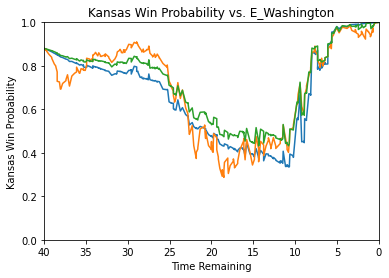

In [110]:
times, teamA_win_prob, teamA_win_prob_og, espn_times, espn_prob = prob_curve('Kansas', 0.494, 16.5, 'E_Washington', 0.542, 15.9)
#orange = espn 
#blue = efg model
#green = simple model

Enter a win probability url:  https://www.espn.com/mens-college-basketball/game/_/gameId/401301734
Enter a play by play url:  https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401301734


https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401301734&xhr=1


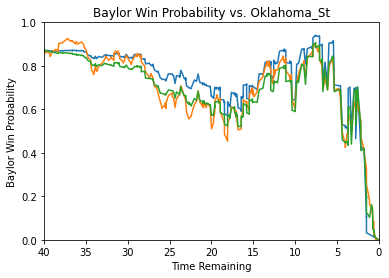

In [111]:
times, teamA_win_prob, espn_times, espn_prob = prob_curve('Baylor', 0.565, 17, 'Oklahoma_St', 0.512, 15.7)

In [10]:
def log_loss(times, efg, simple, espn_times, espn_prob, kenpom, teamA_win):
    teamA_win_list = []
    for i in times:
        teamA_win_list.append(teamA_win)
    a_dict = {'Time': times, 'EFG Model': efg, 'Simple Model': simple, 'ESPN Time': espn_times, 'ESPN': espn_prob, 'KenPom Model': kenpom, 'Team A Win': teamA_win}
    df = pd.DataFrame(a_dict)
    df['Simple Model Log Loss'] = -(df['Team A Win'] * np.log(df['Simple Model']) + (1-df['Team A Win']) * np.log(1-df['Simple Model']))
    df['KenPom Model Log Loss'] = -(df['Team A Win'] * np.log(df['KenPom Model']) + (1-df['Team A Win']) * np.log(1-df['KenPom Model']))
    df['EFG Model Log Loss'] = -(df['Team A Win'] * np.log(df['EFG Model']) + (1-df['Team A Win']) * np.log(1-df['EFG Model']))
    df['ESPN Log Loss'] = -(df['Team A Win'] * np.log(df['ESPN']) + (1-df['Team A Win']) * np.log(1-df['ESPN']))
    
    return df

In [11]:
def log_loss_totals(teamA, teamA_off_efg, teamA_def_efg, possession_time_A, teamA_adj_oe, teamA_adj_de, teamA_adj_tempo, teamB, teamB_off_efg, teamB_def_efg, possession_time_B, teamB_adj_oe, teamB_adj_de, teamB_adj_tempo, teamA_win):
    times, efg, simple, espn_times, espn_prob, kenpom = prob_curve(teamA, teamA_off_efg, teamA_def_efg, possession_time_A, teamA_adj_oe, teamA_adj_de, teamA_adj_tempo, teamB, teamB_off_efg, teamB_def_efg, possession_time_B, teamB_adj_oe, teamB_adj_de, teamB_adj_tempo)
    df = log_loss(times, efg, simple, espn_times, espn_prob, kenpom, teamA_win)
    ESPN_total = df['ESPN Log Loss'].sum()
    simple_model_total = df['Simple Model Log Loss'].sum()
    efg_model_total = df['EFG Model Log Loss']. sum()
    kenpom_model_total = df['KenPom Model Log Loss'].sum()
    print('ESPN Log Loss: ', ESPN_total, 'Simple Model Log Loss: ', simple_model_total, 'EFG Model Log Loss: ', efg_model_total, 'KenPom Model Log Loss: ', kenpom_model_total)
    return ESPN_total, simple_model_total, efg_model_total, kenpom_model_total

Enter a win probability url:  https://www.espn.com/mens-college-basketball/game/_/gameId/401368378
Enter a play by play url:  https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401368378


https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401368378&xhr=1


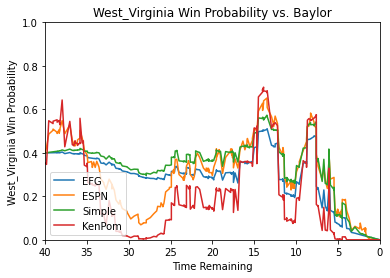

ESPN Log Loss:  inf Simple Model Log Loss:  inf EFG Model Log Loss:  inf KenPom Model Log Loss:  inf


/opt/conda/envs/common/lib/python3.7/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
ESPN_total, simple_model_total, efg_model_total, kenpom_model_total = log_loss_totals('West_Virginia', 0.478, 0.482, 18.6, 107.1, 93.0, 68.1, 'Baylor', 0.551, 0.469, 16.6, 118.7, 90.7, 68.8, 1)


In [ ]:
ESPN_total, simple_model_total, efg_model_total, kenpom_model_total = log_loss_totals('Kansas', 0.566, 0.474, 16.3, 120.5, 95.4, 70.7, 'Oklahoma', 0.568, 0.470, 17.3, 110.4, 94.0, 67.3, 1)


Enter a win probability url:  https://www.espn.com/mens-college-basketball/game/_/gameId/401398458
Enter a play by play url:  https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401398458


https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401398458&xhr=1


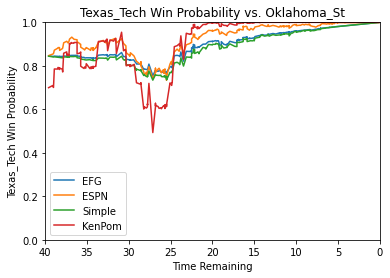

ESPN Log Loss:  23.03068659339433 Simple Model Log Loss:  37.8473911538719 EFG Model Log Loss:  33.86471455001098 KenPom Model Log Loss:  30.793061294437816


/opt/conda/envs/common/lib/python3.7/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
ESPN_total, simple_model_total, efg_model_total, kenpom_model_total = log_loss_totals('Texas_Tech', 0.539, 0.458, 18.2, 110.5, 88.5, 65.9, 'Oklahoma_St', 0.486, 0.455, 15.9, 104.8, 91.4, 70.5, 1)


Enter a win probability url:  https://www.espn.com/mens-college-basketball/game/_/gameId/401364379
Enter a play by play url:  https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401364379


https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401364379&xhr=1


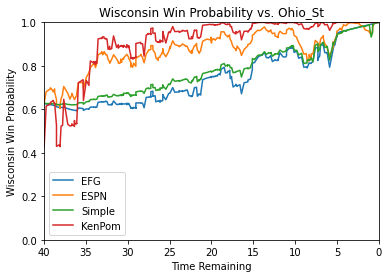

ESPN Log Loss:  41.7474627722147 Simple Model Log Loss:  78.46545884663658 EFG Model Log Loss:  90.39690894125292 KenPom Model Log Loss:  30.81606853463231


/opt/conda/envs/common/lib/python3.7/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
ESPN_total, simple_model_total, efg_model_total, kenpom_model_total = log_loss_totals('Wisconsin', 0.472, 0.486, 17.6, 112, 94.4, 66.9, 'Ohio_St', 0.567, 0.462, 18.4, 117.3, 97.4, 67.7, 1)


In [12]:
ESPN_total, simple_model_total, efg_model_total, kenpom_model_total = log_loss_totals('Villanova', 0.514, 0.474, 19.6, 118.6, 92.7, 62.7, 'Xavier', 0.529, 0.45, 16.1, 114.8, 94.8, 71.4, 1)


KeyboardInterrupt: Interrupted by user

Enter a win probability url:  https://www.espn.com/mens-college-basketball/game/_/gameId/401364377
Enter a play by play url:  https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401364377


https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401364377&xhr=1


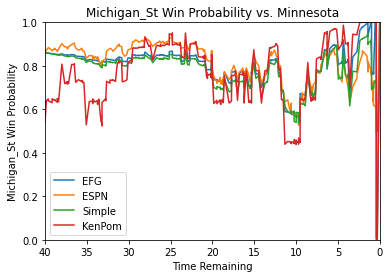

ESPN Log Loss:  67.45027652332138 Simple Model Log Loss:  79.65382159676861 EFG Model Log Loss:  78.29723219324728 KenPom Model Log Loss:  inf


/opt/conda/envs/common/lib/python3.7/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
ESPN_total, simple_model_total, efg_model_total, kenpom_model_total = log_loss_totals('Michigan_St', 0.533, 0.444, 16, 113.4, 92.9, 70.4, 'Minnesota', 0.513, 0.464, 18.2, 106.8, 97.8, 67.3, 1)


Enter a win probability url:  https://www.espn.com/mens-college-basketball/game/_/gameId/401371311
Enter a play by play url:  https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401371311


https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401371311&xhr=1


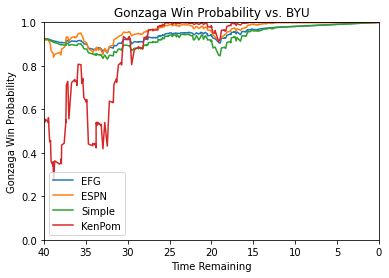

ESPN Log Loss:  11.51143330756264 Simple Model Log Loss:  20.865492171757626 EFG Model Log Loss:  16.635267078369765 KenPom Model Log Loss:  46.805359890500505


/opt/conda/envs/common/lib/python3.7/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [19]:
ESPN_total, simple_model_total, efg_model_total, kenpom_model_total = log_loss_totals('Gonzaga', 0.588, 0.431, 14.7, 122.1, 92.2, 73.7, 'BYU', 0.498, 0.429, 18.2, 110.9, 92.3, 69.5, 1)


Enter a win probability url:  https://www.espn.com/mens-college-basketball/game/_/gameId/401310902
Enter a play by play url:  https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401310902


https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401310902&xhr=1


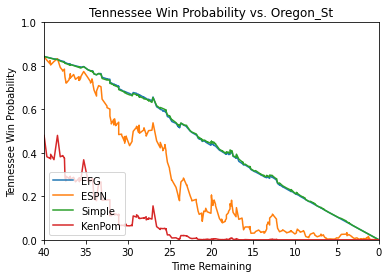

ESPN Log Loss:  123.15408908580122 Simple Model Log Loss:  208.5820559639569 EFG Model Log Loss:  208.19710067241124 KenPom Model Log Loss:  23.657324835480047


/opt/conda/envs/common/lib/python3.7/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [30]:
ESPN_total, simple_model_total, efg_model_total, kenpom_model_total = log_loss_totals('Tennessee', 0.496, 0.463, 17.2, 108, 88.1, 67.1,'Oregon_St', 0.49, 0.486, 18.9, 112.1, 95.7, 65.5, 0)


Enter a win probability url:  https://www.espn.com/mens-college-basketball/game/_/gameId/401310925
Enter a play by play url:  https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401310925


https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401310925&xhr=1


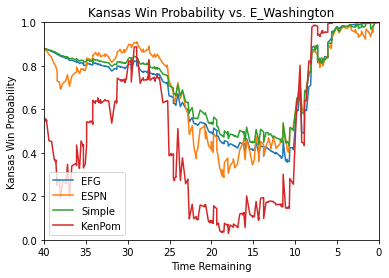

ESPN Log Loss:  124.26698347338345 Simple Model Log Loss:  106.84663303237963 EFG Model Log Loss:  123.05054146390711 KenPom Model Log Loss:  306.78837658386624


/opt/conda/envs/common/lib/python3.7/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [32]:
ESPN_total, simple_model_total, efg_model_total, kenpom_model_total = log_loss_totals('Kansas', 0.494, 0.48, 16.5, 110.1, 90.2, 68.2, 'E_Washington', 0.542, 0.48, 15.9,109.5, 101.3, 72.2, 1)


Enter a win probability url:  https://www.espn.com/mens-college-basketball/game/_/gameId/401310876
Enter a play by play url:  https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401310876


https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401310876&xhr=1


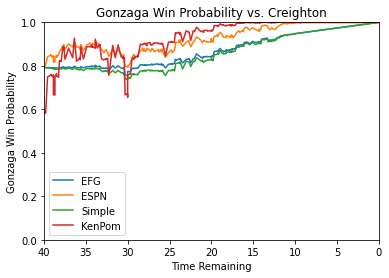

ESPN Log Loss:  23.50570445093771 Simple Model Log Loss:  46.813148326247514 EFG Model Log Loss:  43.028498277400104 KenPom Model Log Loss:  23.22956781903448


/opt/conda/envs/common/lib/python3.7/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
ESPN_total, simple_model_total, efg_model_total, kenpom_model_total = log_loss_totals('Gonzaga', 0.61, 0.477, 14.4, 126.4, 89.9, 73.8, 'Creighton', 0.55, 0.47, 16.1, 113.4, 92.8, 68.7, 1)


Enter a win probability url:  https://www.espn.com/mens-college-basketball/game/_/gameId/401258806
Enter a play by play url:  https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401258806


https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401258806&xhr=1


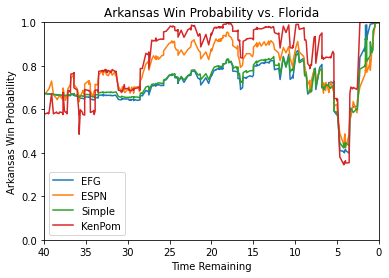

ESPN Log Loss:  79.1718112397139 Simple Model Log Loss:  102.37183963376239 EFG Model Log Loss:  104.42106674785654 KenPom Model Log Loss:  63.89188379439297


/opt/conda/envs/common/lib/python3.7/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
ESPN_total, simple_model_total, efg_model_total, kenpom_model_total = log_loss_totals('Arkansas', 0.507, 0.479, 16, 111.1, 89.6, 72.6, 'Florida', 0.531, 0.478, 16.6, 111.0, 94.1, 68.3, 1)


Enter a win probability url:  https://www.espn.com/mens-college-basketball/game/_/gameId/401301734
Enter a play by play url:  https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401301734


https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401301734&xhr=1


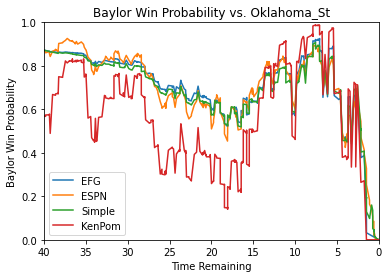

ESPN Log Loss:  458.523450262029 Simple Model Log Loss:  435.02585655865516 EFG Model Log Loss:  456.4256434451398 KenPom Model Log Loss:  383.54948518603817


/opt/conda/envs/common/lib/python3.7/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
ESPN_total, simple_model_total, efg_model_total, kenpom_model_total = log_loss_totals('Baylor', 0.565, 0.489, 17, 125, 91.1, 67.4, 'Oklahoma_St', 0.512, 0.471, 15.7, 109.6, 90.7, 72.4, 0)


Enter a win probability url:  https://www.espn.com/mens-college-basketball/game/_/gameId/401263388
Enter a play by play url:  https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401263388


https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401263388&xhr=1


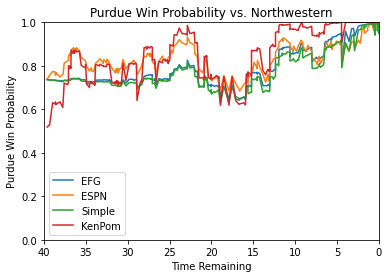

ESPN Log Loss:  50.99065488527913 Simple Model Log Loss:  73.98942529571552 EFG Model Log Loss:  68.0464459567574 KenPom Model Log Loss:  47.81960342930835


/opt/conda/envs/common/lib/python3.7/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [15]:
ESPN_total, simple_model_total, efg_model_total, kenpom_model_total = log_loss_totals('Purdue', 0.51, 0.488, 18.4, 113.3, 92.9, 66.1, 'Northwestern', 0.503, 0.502, 16.4, 104.3, 93.4, 68.4, 1)


Enter a win probability url:  https://www.espn.com/mens-college-basketball/game/_/gameId/401310900
Enter a play by play url:  https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401310900


https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401310900&xhr=1


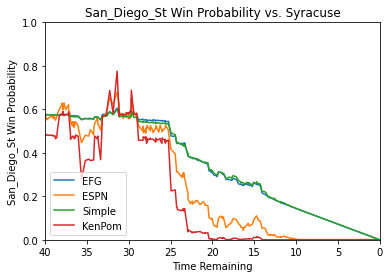

ESPN Log Loss:  95.94894352478724 Simple Model Log Loss:  127.66008973736004 EFG Model Log Loss:  128.34130927072277 KenPom Model Log Loss:  76.8804084439319


/opt/conda/envs/common/lib/python3.7/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [17]:
ESPN_total, simple_model_total, efg_model_total, kenpom_model_total = log_loss_totals('San_Diego_St', 0.524, 0.475, 16.9, 111, 91.1, 65.5, 'Syracuse', 0.512, 0.48, 16.4, 113.7, 96.9, 68.6, 0)


Enter a win probability url:  https://www.espn.com/mens-college-basketball/game/_/gameId/401310872
Enter a play by play url:  https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401310872


https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401310872&xhr=1


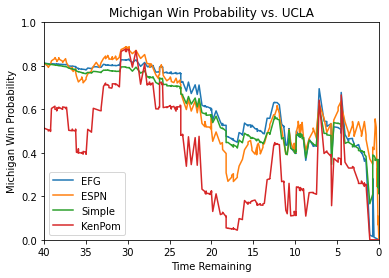

ESPN Log Loss:  282.30709215889783 Simple Model Log Loss:  267.3092410204784 EFG Model Log Loss:  282.50873874008215 KenPom Model Log Loss:  160.4681359335637


/opt/conda/envs/common/lib/python3.7/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
ESPN_total, simple_model_total, efg_model_total, kenpom_model_total = log_loss_totals('Michigan', 0.547, 0.444, 17.5, 117.6, 87.9, 66.6, 'UCLA', 0.52, 0.504, 19, 116.9, 94.5, 63.8, 0)


Enter a win probability url:  https://www.espn.com/mens-college-basketball/game/_/gameId/401310872
Enter a play by play url:  https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401310872


https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/401310872&xhr=1


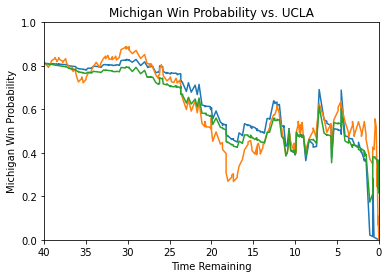

ESPN Log Loss:  282.30709215889783 Simple Model Log Loss:  267.4037846927651 EFG Model Log Loss:  282.435197543095


/opt/conda/envs/common/lib/python3.7/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [19]:
ESPN_total, simple_model_total, efg_model_total = log_loss_totals('Michigan', 0.547, 0.444, 17.5, 'UCLA', 0.52, 0.504, 19, 0)